# Survival impact of InstaPrism cell-type fractions in Schildkraut HGSOC

We leveraged bulk RNA-seq data from the 588 HGSOC tumor samples from the Schildkraut cohorts (Table 1). To estimate the cell composition of the tumor samples, we used bulk RNA-seq deconvolution on the raw count profiles using a cell reference that combined published HGSOC scRNA-seq datasets with adipose tissue snRNA-seq datasets (Fig. 1a). For the Schildkraut samples, a pathologist reviewed slides to select areas with tumor tissue for downstream analyses, so the RNA-seq data primarily represented cell types that are within the tumor, and not the surrounding tissue. The obtained estimated cell-type proportions for all samples are shown in Supplemental Fig. 1. 

We limited survival analyses to individuals with known BMI and International Federation of Gynecology and Obstetrics (FIGO) stage, resulting in 566 patients in total. After deconvolution, we multiplied the predicted adipocyte proportions (0-1) by 10 so that hazard ratios (HRs) reflect a 10% increase in adipocyte content, and we stratified all CPH models by FIGO stage to satisfy proportional-hazards assumptions. Results are reported for both a main model (stage-stratified, adjusted for age, BMI, and race, n = 566), and a restricted model (including only individuals who were known to have received adjuvant chemotherapy and additionally adjusted for residual disease, n = 262).

**Results** 

Adipocyte abundance was associated with increased mortality (Fig. 1b). In the main model, every 10-percentage-point rise in adipocyte content increased the hazard of death by 41% (HR = 1.41, 95% CI 1.18–1.70, p = 0.0002). The association was similar in the restricted model (HR = 1.41, 95% CI 1.07-1.84, p = 0.013). 

As expected, immune cell abundance was significantly associated with improved survival in the main model (HR = 0.82, 95% CI 0.69-0.97, p = 0.024), with a similar magnitude in the restricted model (HR = 0.80, 95% CI 0.61-1.03, p = 0.085) (Supplemental Figure 3b). Stromal and epithelial content were not markedly associated with survival (Supplemental Figure 3c-d).  


In [ ]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
import numpy as np, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test

sys.path.insert(1, "../../")
sys.path.insert(1, "../")

import src.hp as hp
import src.params as params

pd.set_option("display.max_rows", 100)
plt.style.use("default")

np.random.seed(90)

In [39]:
cell_types_to_use = ["Adipocytes"]  # Adipocytes, Stromal, Immune, Epithelial
complete_case = True
use_interview_time = True

In [40]:
map_stage = True
remove_unknown_stage = True
remove_999_BMI = True
kaplan_meier = True

## Paths

In [41]:
base_path = os.path.dirname(os.getcwd())
meta_path = os.path.join(base_path, "input_data/metadata.xlsx")

### Formatting for below plots, etc.

In [42]:
if complete_case:
    remove_treatment = False
    remove_pts_with_unknowns = True

else:
    remove_treatment = True
    remove_pts_with_unknowns = False

In [43]:
## The order for the plots below
desired_order = [
    "Age",
    "BMI",
    "Race: Black",
    "Residual: < 1cm",
    "Residual: ≥ 1cm",
]
if remove_treatment:
    desired_order.remove("Residual: < 1cm")
    desired_order.remove("Residual: ≥ 1cm")
desired_order

['Age', 'BMI', 'Race: Black', 'Residual: < 1cm', 'Residual: ≥ 1cm']

In [44]:
# continuous covariates to keep “as is”
cont_cols = ["Age", "BMI"]

## Load InstaPrism cell-fraction tables (processed) and metadata

Proportions

In [45]:
props = pd.read_csv(
    os.path.join(base_path, "input_data/proportions_sch.csv"), index_col=0
)
props

,SampleID,Plasma cells,B cells,Endothelial cells,T cells,Monocytes,Fibroblasts,NK cells,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset,suid,ID
0,18341X10,4.919765e-49,0.052767,0.029870,1.833554e-26,1.727071e-60,7.074672e-105,8.375315e-10,0.746341,1.257780e-139,3.590420e-30,2.867046e-78,1.185148e-02,1.538137e-57,0.0,0.159171,SchildkrautB,18341X10,45369
1,18341X12,9.351753e-92,0.027159,0.011666,5.972580e-66,2.258210e-157,8.180384e-107,8.135649e-61,0.848153,3.276474e-210,2.054386e-103,1.247009e-85,2.337775e-128,1.452291e-115,0.0,0.113022,SchildkrautB,18341X12,47261
2,18341X13,6.998799e-32,0.014663,0.041547,1.004614e-23,3.232466e-34,1.225464e-02,9.550579e-19,0.819028,1.104356e-115,3.157063e-69,7.123720e-41,2.994756e-02,1.850941e-63,0.0,0.082561,SchildkrautB,18341X13,47791
3,18341X14,2.410384e-97,0.162711,0.022343,2.056824e-52,5.485488e-33,2.751866e-120,7.904174e-39,0.642545,4.774011e-154,1.326676e-75,2.334007e-77,1.516542e-02,1.488048e-80,0.0,0.157235,SchildkrautB,18341X14,47916
4,18341X15,3.439318e-76,0.050581,0.055021,5.687981e-28,5.314872e-52,8.961526e-02,2.919113e-22,0.649017,7.625379e-122,1.873123e-52,3.487465e-81,1.419715e-02,4.216693e-41,0.0,0.141568,SchildkrautB,18341X15,48002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,20160X95,1.442627e-108,0.136578,0.014420,3.410104e-30,3.267116e-82,7.666630e-23,1.501224e-35,0.710289,6.509988e-151,4.903142e-78,8.571710e-105,3.473745e-03,5.671299e-79,0.0,0.135240,SchildkrautW,20160X95,47786
584,20160X96,1.359916e-92,0.190881,0.017396,5.383974e-33,2.734703e-86,1.156925e-02,1.945285e-24,0.592805,1.063562e-147,5.374615e-82,8.551669e-96,1.270617e-02,4.370517e-04,0.0,0.174205,SchildkrautW,20160X96,47903
585,20160X97,7.862780e-79,0.102850,0.053137,8.610293e-03,1.076987e-46,4.237821e-02,1.467756e-05,0.656171,3.397744e-114,5.089409e-39,1.625064e-79,2.253584e-02,9.865474e-05,0.0,0.114204,SchildkrautW,20160X97,47926
586,20160X98,1.245316e-60,0.127050,0.034344,1.345753e-16,5.846372e-04,2.787547e-02,2.169830e-04,0.673204,4.422809e-95,4.998254e-48,3.881728e-35,5.796692e-04,4.236351e-47,0.0,0.136146,SchildkrautW,20160X98,47937


In [ ]:
## Which cell types to use
if cell_types_to_use == ["Immune"]:
    cell_types_to_use_grouped = params.immune_cells
    desired_order = desired_order + ["Immune"]

elif cell_types_to_use == ["Stromal"]:
    cell_types_to_use_grouped = params.stromal_cells
    desired_order = desired_order + ["Stromal"]

elif cell_types_to_use == ["Adipocytes"]:
    cell_types_to_use_grouped = ["Adipocytes"]
    desired_order = desired_order + ["Adipocytes"]

elif cell_types_to_use == ["Epithelial"]:
    props["Epithelial"] = props["Epithelial cells"]
    cell_types_to_use_grouped = ["Epithelial"]
    desired_order = desired_order + ["Epithelial"]

props[cell_types_to_use[0]] = props[cell_types_to_use_grouped].sum(axis=1)

props[cell_types_to_use[0]] = props[cell_types_to_use[0]] * 10

props

,SampleID,Plasma cells,B cells,Endothelial cells,T cells,Monocytes,Fibroblasts,NK cells,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset,suid,ID
0,18341X10,4.919765e-49,0.052767,0.029870,1.833554e-26,1.727071e-60,7.074672e-105,8.375315e-10,0.746341,1.257780e-139,3.590420e-30,2.867046e-78,1.185148e-02,1.538137e-57,0.0,1.591710,SchildkrautB,18341X10,45369
1,18341X12,9.351753e-92,0.027159,0.011666,5.972580e-66,2.258210e-157,8.180384e-107,8.135649e-61,0.848153,3.276474e-210,2.054386e-103,1.247009e-85,2.337775e-128,1.452291e-115,0.0,1.130216,SchildkrautB,18341X12,47261
2,18341X13,6.998799e-32,0.014663,0.041547,1.004614e-23,3.232466e-34,1.225464e-02,9.550579e-19,0.819028,1.104356e-115,3.157063e-69,7.123720e-41,2.994756e-02,1.850941e-63,0.0,0.825608,SchildkrautB,18341X13,47791
3,18341X14,2.410384e-97,0.162711,0.022343,2.056824e-52,5.485488e-33,2.751866e-120,7.904174e-39,0.642545,4.774011e-154,1.326676e-75,2.334007e-77,1.516542e-02,1.488048e-80,0.0,1.572353,SchildkrautB,18341X14,47916
4,18341X15,3.439318e-76,0.050581,0.055021,5.687981e-28,5.314872e-52,8.961526e-02,2.919113e-22,0.649017,7.625379e-122,1.873123e-52,3.487465e-81,1.419715e-02,4.216693e-41,0.0,1.415675,SchildkrautB,18341X15,48002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,20160X95,1.442627e-108,0.136578,0.014420,3.410104e-30,3.267116e-82,7.666630e-23,1.501224e-35,0.710289,6.509988e-151,4.903142e-78,8.571710e-105,3.473745e-03,5.671299e-79,0.0,1.352398,SchildkrautW,20160X95,47786
584,20160X96,1.359916e-92,0.190881,0.017396,5.383974e-33,2.734703e-86,1.156925e-02,1.945285e-24,0.592805,1.063562e-147,5.374615e-82,8.551669e-96,1.270617e-02,4.370517e-04,0.0,1.742051,SchildkrautW,20160X96,47903
585,20160X97,7.862780e-79,0.102850,0.053137,8.610293e-03,1.076987e-46,4.237821e-02,1.467756e-05,0.656171,3.397744e-114,5.089409e-39,1.625064e-79,2.253584e-02,9.865474e-05,0.0,1.142044,SchildkrautW,20160X97,47926
586,20160X98,1.245316e-60,0.127050,0.034344,1.345753e-16,5.846372e-04,2.787547e-02,2.169830e-04,0.673204,4.422809e-95,4.998254e-48,3.881728e-35,5.796692e-04,4.236351e-47,0.0,1.361460,SchildkrautW,20160X98,47937


In [47]:
# Keep only the columns of interest
keep_cols = cell_types_to_use + ["SampleID", "Dataset", "ID"]
props = props[keep_cols]

## Merge, encode categorical covariates

### Build the analysis table  (clinical + cell fractions)


In [48]:
renaming = hp.get_variable_renaming()
renaming.pop("tissue", None)

'Tissue'

Metadata

In [49]:
## Importing and renaming metadata

# ------------------------------ clinical columns -----------------
meta_full = (
    pd.read_excel(meta_path, sheet_name=0)
    .rename(columns=str.strip)
    .rename(columns=renaming)
)

meta_full = meta_full[renaming.values()]

meta_full["Stage"] = pd.to_numeric(meta_full["Stage"], errors="coerce")

meta_full["Event"] = meta_full["Event"].astype(int)
meta_full["Time-Years"] = meta_full["Time_Yrs"]
meta_full.pop("Time_Yrs")
meta_full["Time-Days"] = meta_full["Time-Years"] * 365.22

# Removing patients that received adj. therapy in the complete case model
if complete_case:
    print("filtering samples that did not receive AdjTx")
    print("Original n =", meta_full.shape[0])
    to_rm_adjtx = meta_full[meta_full["AdjTx"] == 2]["ID"].unique().tolist()
    meta_full = meta_full[~meta_full["ID"].isin(to_rm_adjtx)]
    props = props[~props["ID"].isin(to_rm_adjtx)]
    print("New n =", meta_full.shape[0])


meta_full

filtering samples that did not receive AdjTx
Original n = 588
New n = 581


,ID,Age,Event,Stage,Race,Debulk,Hispanic,BMI,NeoTx,AdjTx,Residual,Time-Years,Time-Days
0,40143,63,1,3,1,2.0,2,23.218229,2.0,1.0,4.0,8.739220,3191.737824
1,41377,54,1,3,1,2.0,2,17.428942,2.0,NaN,3.0,1.180014,430.964599
2,41387,55,1,3,2,1.0,2,45.470350,2.0,1.0,2.0,11.983573,4376.640495
3,41391,60,1,3,1,2.0,2,31.340800,2.0,NaN,3.0,4.993840,1823.850185
4,41435,59,1,3,1,NaN,2,23.922658,NaN,NaN,NaN,4.057495,1481.878275
...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,310266,40,0,3,2,NaN,2,28.349557,NaN,NaN,NaN,9.702186,3543.432295
584,320012,66,0,3,2,2.0,2,37.677475,2.0,1.0,4.0,11.767760,4297.821147
585,320025,60,1,3,2,2.0,2,38.740537,2.0,1.0,3.0,6.827869,2493.674262
586,320043,57,1,3,2,2.0,2,19.854802,2.0,1.0,4.0,1.553425,567.341754


In [50]:
meta_full

,ID,Age,Event,Stage,Race,Debulk,Hispanic,BMI,NeoTx,AdjTx,Residual,Time-Years,Time-Days
0,40143,63,1,3,1,2.0,2,23.218229,2.0,1.0,4.0,8.739220,3191.737824
1,41377,54,1,3,1,2.0,2,17.428942,2.0,NaN,3.0,1.180014,430.964599
2,41387,55,1,3,2,1.0,2,45.470350,2.0,1.0,2.0,11.983573,4376.640495
3,41391,60,1,3,1,2.0,2,31.340800,2.0,NaN,3.0,4.993840,1823.850185
4,41435,59,1,3,1,NaN,2,23.922658,NaN,NaN,NaN,4.057495,1481.878275
...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,310266,40,0,3,2,NaN,2,28.349557,NaN,NaN,NaN,9.702186,3543.432295
584,320012,66,0,3,2,2.0,2,37.677475,2.0,1.0,4.0,11.767760,4297.821147
585,320025,60,1,3,2,2.0,2,38.740537,2.0,1.0,3.0,6.827869,2493.674262
586,320043,57,1,3,2,2.0,2,19.854802,2.0,1.0,4.0,1.553425,567.341754


In [51]:
if use_interview_time:
    # ------------------------------ clinical columns -----------------
    meta_new_path = os.path.join(base_path, "input_data/AACES_clinical.csv")
    meta_new = pd.read_csv(meta_new_path)
    meta_new["ID"] = meta_new.suid
    meta_new.index = meta_new.ID

    intersect = np.intersect1d(meta_full["ID"].unique(), meta_new.index.unique())
    meta_new = meta_new.loc[intersect]
    old_idx = meta_full.index
    meta_full.index = meta_full.ID

    meta_full["Time-Days"] = meta_new["days_int_to_event"]
    meta_full["Time-Years"] = meta_new["days_int_to_event"] / 365.22
    meta_full["Event"] = meta_new["vital_status_fin"].astype(float)

    meta_full.index = old_idx

Filtering samples

In [52]:
# Mapping unknown residual treatment size to >=1cm
meta_full["Residual"] = meta_full["Residual"].replace(
    4.0, 3.0
)  ## Making the residual disaease unknow size

if remove_unknown_stage:
    first = meta_full.shape[0]
    meta_full = meta_full[meta_full["Stage"] != 9]
    print("Removed for unknown stage: ", first - meta_full.shape[0])

if remove_999_BMI:
    first = meta_full.shape[0]
    meta_full = meta_full[meta_full["BMI"] != 999]
    print("Removed for BMI 999: ", first - meta_full.shape[0])

# In no case we'd use Hispanic variable:
meta_full.drop(columns=["Hispanic"], inplace=True)

# We are removing debulking treatment that includes CA125.
meta_full.drop(columns=["Debulk"], inplace=True)
meta_full.drop(columns=["NeoTx"], inplace=True)
meta_full.shape

Removed for unknown stage:  9
Removed for BMI 999:  13


(559, 10)

In [53]:
summary_black = hp.meta_summary_table(meta_full[meta_full.Race == 2])
summary_black

,Clinical Variable,Category/Statistic,Value
0,Race,Race = 2,256.00
1,Age at Diagnosis,N,256.00
2,Age at Diagnosis,Mean,57.92
3,Age at Diagnosis,Std,9.80
4,Age at Diagnosis,Min,35.00
5,Age at Diagnosis,Max,78.00
6,Vital Status,Deceased,192.00
7,Vital Status,Alive/Censored,64.00
8,Years from diagnosis to last follow up,N,256.00
9,Years from diagnosis to last follow up,Mean,5.38


In [54]:
summary_white = hp.meta_summary_table(meta_full[meta_full.Race == 1])
summary_white

,Clinical Variable,Category/Statistic,Value
0,Race,Race = 1,303.00
1,Age at Diagnosis,N,303.00
2,Age at Diagnosis,Mean,58.45
3,Age at Diagnosis,Std,9.36
4,Age at Diagnosis,Min,31.00
5,Age at Diagnosis,Max,74.00
6,Vital Status,Deceased,258.00
7,Vital Status,Alive/Censored,45.00
8,Years from diagnosis to last follow up,N,303.00
9,Years from diagnosis to last follow up,Mean,6.04


In [55]:
# If we remove treatment we only keep Race and Stage of the categoricals.
if remove_treatment:
    cat_cols = ["Stage", "Race"]
else:
    # Match Notebook 1: Stage, Race, Residual, AdjTx as categoricals
    cat_cols = ["Stage", "Race", "Residual", "AdjTx"]

meta_full[cat_cols] = meta_full[cat_cols].astype("category")
meta_full.columns

Index(['ID', 'Age', 'Event', 'Stage', 'Race', 'BMI', 'AdjTx', 'Residual',
       'Time-Years', 'Time-Days'],
      dtype='object')

In [56]:
# ------------------------------ merge meta + props ----------------------------
# every SampleID maps to a unique suid)
analysis = props.merge(meta_full, on="ID", how="inner")

print(f"Using: {analysis.shape[0]} rows, {analysis['ID'].nunique()} patients")

analysis

Using: 559 rows, 559 patients


,Adipocytes,SampleID,Dataset,ID,Age,Event,Stage,Race,BMI,AdjTx,Residual,Time-Years,Time-Days
0,1.591710,18341X10,SchildkrautB,45369,53,1.0,3,2,31.110562,1.0,3.0,1.256777,459.0
1,1.130216,18341X12,SchildkrautB,47261,57,1.0,3,2,29.448927,NaN,NaN,4.531515,1655.0
2,0.825608,18341X13,SchildkrautB,47791,45,1.0,3,2,40.981420,NaN,NaN,4.224851,1543.0
3,1.572353,18341X14,SchildkrautB,47916,68,1.0,4,2,28.928061,NaN,NaN,1.766059,645.0
4,1.415675,18341X15,SchildkrautB,48002,44,1.0,3,2,24.991295,1.0,2.0,1.130825,413.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,1.352398,20160X95,SchildkrautW,47786,68,1.0,3,1,31.538819,NaN,NaN,1.785225,652.0
555,1.742051,20160X96,SchildkrautW,47903,45,1.0,3,1,20.410354,NaN,NaN,2.540934,928.0
556,1.142044,20160X97,SchildkrautW,47926,52,0.0,3,1,34.458370,NaN,NaN,14.112042,5154.0
557,1.361460,20160X98,SchildkrautW,47937,43,1.0,3,1,20.156950,1.0,2.0,2.724385,995.0


In [57]:
if map_stage:
    stage_map = {1: 1, 2: 1, 3: 2, 4: 2}
    analysis["Stage"] = analysis.Stage.map(stage_map)

if remove_pts_with_unknowns:
    print("Going from: ", analysis.shape)
    # require known Residual AND known AdjTx
    analysis = analysis.dropna(subset=["Residual", "AdjTx"])
    print("To: ", analysis.shape)

Going from:  (559, 13)
To:  (262, 13)


In [58]:
if complete_case:
    print("Saving complete case IDs")
    analysis["ID"].to_csv(
        f"{os.getcwd()}/../results/IDs_complete_case.csv", index=False
    )
elif complete_case == False:
    print("Saving reduced  IDs")
    analysis["ID"].to_csv(f"{os.getcwd()}/../results/IDs_reduced_cov.csv", index=False)

Saving complete case IDs


In [59]:
if remove_treatment:
    cols = [
        "Age",
        "Event",
        "Time-Years",
        "BMI",
        "Time-Days",
        "Stage",
        "Residual",
    ]

    cat_cols = ["Race"]
else:
    cols = ["Age", "Event", "Time-Years", "BMI", "Time-Days", "Stage"]

    # Match Notebook 1: include Residual, AdjTx, Race
    cat_cols = ["Residual", "Race"]

# Get dummys for categorical columns with more than 2 cats (NaN counts as category)
dummies = pd.get_dummies(analysis, columns=cat_cols, drop_first=True, prefix_sep="_")

dummies.drop(columns=cols, inplace=True)  # remove original covariates
dummies.drop(columns=props.columns, inplace=True)  # remove original proportions
dummies.drop(columns=["AdjTx"], inplace=True)
dummies

,Residual_2.0,Residual_3.0,Race_2
0,False,True,True
4,True,False,True
9,True,False,True
17,True,False,True
18,True,False,True
...,...,...,...
549,False,True,False
550,True,False,False
551,True,False,False
557,True,False,False


In [60]:
for col in dummies:
    print(dummies[col].value_counts(dropna=False))

Residual_2.0
False    172
True      90
Name: count, dtype: int64
Residual_3.0
False    187
True      75
Name: count, dtype: int64
Race_2
True     151
False    111
Name: count, dtype: int64


In [61]:
# Put together the analysis DataFrame
# (keep the original categorical columns for later use)
analysis_enc = pd.concat([analysis, dummies], axis=1)  # Columns that go into the model
cell_cols = props.columns.difference(["SampleID", "Dataset", "ID"])  # fractions
covars = cont_cols + list(dummies.columns) + list(cell_cols) + ["Stage"]

covars

['Age', 'BMI', 'Residual_2.0', 'Residual_3.0', 'Race_2', 'Adipocytes', 'Stage']

In [62]:
cox_df = analysis_enc[["Time-Days", "Event"] + covars].copy()

if "Race_2" in cox_df.columns:
    cox_df.rename(columns={"Race_2": "Race: Black"}, inplace=True)
if "Residual_3.0" in cox_df.columns:
    cox_df.rename(columns={"Residual_3.0": "Residual: ≥ 1cm"}, inplace=True)
    cox_df.rename(columns={"Residual_2.0": "Residual: < 1cm"}, inplace=True)

In [63]:
print("Design matrix:", cox_df.shape)
print("Design matrix columns:", cox_df.columns)
cox_df

Design matrix: (262, 9)
Design matrix columns: Index(['Time-Days', 'Event', 'Age', 'BMI', 'Residual: < 1cm',
       'Residual: ≥ 1cm', 'Race: Black', 'Adipocytes', 'Stage'],
      dtype='object')


,Time-Days,Event,Age,BMI,Residual: < 1cm,Residual: ≥ 1cm,Race: Black,Adipocytes,Stage
0,459.0,1.0,53,31.110562,False,True,True,1.591710,2
4,413.0,1.0,44,24.991295,True,False,True,1.415675,2
9,1601.0,1.0,67,32.198190,True,False,True,2.161446,2
17,287.0,1.0,71,23.620798,True,False,True,1.816324,2
18,810.0,1.0,51,21.873770,True,False,True,1.298331,2
...,...,...,...,...,...,...,...,...,...
549,579.0,1.0,47,39.153028,False,True,False,1.334981,2
550,4080.0,1.0,57,43.240248,True,False,False,1.665924,2
551,1880.0,1.0,71,20.892489,True,False,False,1.098901,2
557,995.0,1.0,43,20.156950,True,False,False,1.361460,2


In [64]:
# ------------------------------ fit penalised CoxPH ------------------------------
cph = CoxPHFitter()

cph.fit(
    cox_df,
    show_progress=True,
    strata="Stage",
    duration_col="Time-Days",
    event_col="Event",
)

cph.print_summary(columns=["coef", "exp(coef)", "p", "z"])

cph.check_assumptions(cox_df)

Iteration 1: norm_delta = 4.64e-01, step_size = 0.9500, log_lik = -925.45018, newton_decrement = 1.60e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 4.72e-02, step_size = 0.9500, log_lik = -910.82490, newton_decrement = 2.60e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.04e-03, step_size = 0.9500, log_lik = -910.56666, newton_decrement = 5.52e-04, seconds_since_start = 0.0
Iteration 4: norm_delta = 2.11e-06, step_size = 1.0000, log_lik = -910.56611, newton_decrement = 2.82e-10, seconds_since_start = 0.0
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 262 total observations, 61 right-censored observations>
             duration col = 'Time-Days'
                event col = 'Event'
                   strata = Stage
      baseline estimation = breslow
   number of observations = 262
number of events observed = 201
   partial log-likelihood = -910.57
         time fit was run = 2026-01-16 21:17:24 UTC

---
                 coef exp(coef)    z      p
covariate                                  
Age              0.00      1.00 0.49   0.63
BMI              0.00      1.00 0.09   0.93
Residual: < 1cm  0.35      1.41 1.87   0.06
Residual: ≥ 1cm  0.80      2.23 4.25 <0.005
Race: Black      0.11      1.12 0.68   0.50
Adipocytes       0.34      1.41 2.49   0.01
---
Concordance = 0.62
Partial AIC = 1833.13
log-likelihood ratio test = 29.77 on 6 df
-log2(p) of ll-ratio test = 14.49

Proportional hazard assumption looks okay.


[]

In [65]:
if complete_case:
    title_for_plot = f"Restricted Model (n={cox_df.shape[0]})"
else:
    title_for_plot = f"Main Model (n={cox_df.shape[0]})"

In [66]:
summary_small = (
    cph.summary[["exp(coef)", "p"]]
    .rename(columns={"exp(coef)": "HazardRatio", "p": "P-Value"})
    .reset_index()  # moves the index into a column
    .rename(columns={"covariate": "Covariate"})  # give that column a nicer name
)
summary_small["Model"] = title_for_plot

new_order = ["Model"] + [c for c in summary_small.columns if c != "Model"]
summary_small = summary_small[new_order]
# take a look
display(summary_small.style.hide(axis="index"))
summary_small.to_clipboard(index=False, excel=True)

Model,Covariate,HazardRatio,P-Value
Restricted Model (n=262),Age,1.003780,0.625593
Restricted Model (n=262),BMI,1.000878,0.928750
Restricted Model (n=262),Residual: < 1cm,1.413145,0.061430
Restricted Model (n=262),Residual: ≥ 1cm,2.229015,0.000022
Restricted Model (n=262),Race: Black,1.119492,0.495182
Restricted Model (n=262),Adipocytes,1.406061,0.012905


In [67]:
# Full table
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Age,0.003773,1.003780,0.007733,-0.011383,0.018929,0.988682,1.019109,0.0,0.487939,0.625593,0.676704
BMI,0.000878,1.000878,0.009818,-0.018366,0.020122,0.981802,1.020325,0.0,0.089418,0.928750,0.106638
Residual: < 1cm,0.345818,1.413145,0.184891,-0.016562,0.708198,0.983575,2.030329,0.0,1.870388,0.061430,4.024915
Residual: ≥ 1cm,0.801560,2.229015,0.188745,0.431627,1.171493,1.539761,3.226806,0.0,4.246795,0.000022,15.492940
Race: Black,0.112875,1.119492,0.165483,-0.211467,0.437216,0.809396,1.548391,0.0,0.682090,0.495182,1.013970
Adipocytes,0.340792,1.406061,0.137064,0.072152,0.609433,1.074818,1.839387,0.0,2.486373,0.012905,6.275898


In [68]:
# Full table
dataframe_to_save = cph.summary.copy()
title = "Main Model" if not complete_case else "Restricted Model"
dataframe_to_save["model"] = title
save_path = f"{os.getcwd()}/../results/coxph_summary_{cell_types_to_use[0]}_{title.replace(' ','_')}.csv"
dataframe_to_save.to_csv(save_path)

In [69]:
# Full table
dataframe_to_save = cph.summary.copy()
title = "Main Model" if not complete_case else "Restricted Model"
dataframe_to_save["model"] = title
save_path = f"{os.getcwd()}/../results/coxph_summary_{cell_types_to_use[0]}_{title.replace(' ','_')}.csv"
dataframe_to_save.to_csv(save_path)

title_to_open = "Main Model" if complete_case else "Restricted Model"
save_path = f"{os.getcwd()}/../results/coxph_summary_{cell_types_to_use[0]}_{title_to_open.replace(' ','_')}.csv"
other_model = pd.read_csv(save_path, index_col=0)
results = pd.concat([other_model, dataframe_to_save])
results

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p),model
covariate,,,,,,,,,,,,
Age,0.011544,1.011611,0.005043,0.001659,0.021429,1.001661,1.021661,0.0,2.288962,0.022082,5.501015,Main Model
BMI,0.006236,1.006256,0.006612,-0.006722,0.019195,0.993300,1.019381,0.0,0.943226,0.345565,1.532969,Main Model
Race: Black,0.035123,1.035747,0.102732,-0.166229,0.236474,0.846852,1.266775,0.0,0.341885,0.732438,0.449222,Main Model
Adipocytes,0.346500,1.414109,0.093920,0.162420,0.530580,1.176354,1.699917,0.0,3.689311,0.000225,12.118672,Main Model
Age,0.003773,1.003780,0.007733,-0.011383,0.018929,0.988682,1.019109,0.0,0.487939,0.625593,0.676704,Restricted Model
BMI,0.000878,1.000878,0.009818,-0.018366,0.020122,0.981802,1.020325,0.0,0.089418,0.928750,0.106638,Restricted Model
Residual: < 1cm,0.345818,1.413145,0.184891,-0.016562,0.708198,0.983575,2.030329,0.0,1.870388,0.061430,4.024915,Restricted Model
Residual: ≥ 1cm,0.801560,2.229015,0.188745,0.431627,1.171493,1.539761,3.226806,0.0,4.246795,0.000022,15.492940,Restricted Model
Race: Black,0.112875,1.119492,0.165483,-0.211467,0.437216,0.809396,1.548391,0.0,0.682090,0.495182,1.013970,Restricted Model


In [70]:
summ_cop = cph.summary.copy()
summ = results.loc[cell_types_to_use[0]]
col = summ["model"]
summ.index = col.values
summ = summ.sort_index()
summ

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p),model
Main Model,0.346500,1.414109,0.093920,0.162420,0.530580,1.176354,1.699917,0.0,3.689311,0.000225,12.118672,Main Model
Restricted Model,0.340792,1.406061,0.137064,0.072152,0.609433,1.074818,1.839387,0.0,2.486373,0.012905,6.275898,Restricted Model


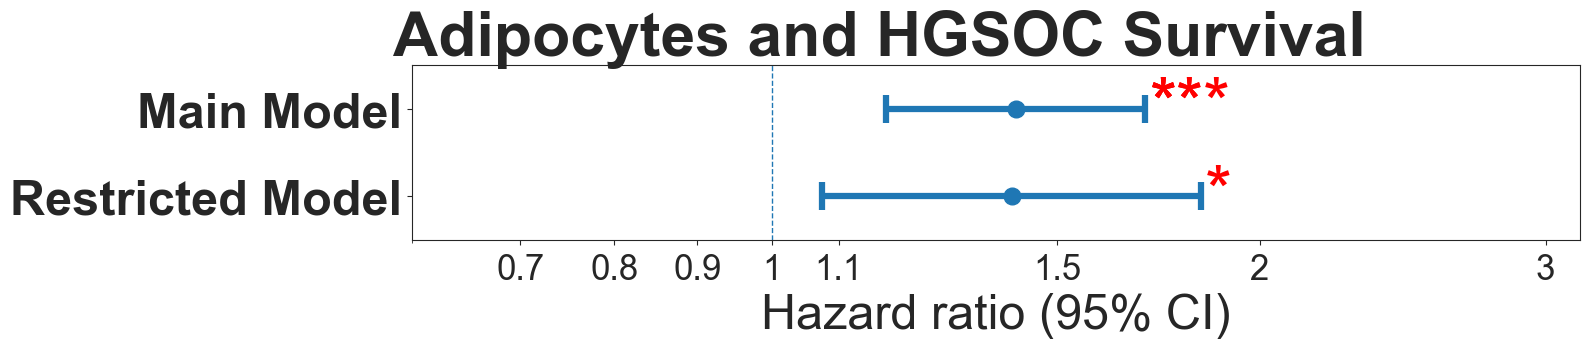

In [71]:
# ------------------------------------------------------------------
# Pull the numbers we need on the log(HR)
# ------------------------------------------------------------------
sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})

# Locate the 95% CI columns, version-agnostic
ci_lower_col = [c for c in summ.columns if c.startswith("coef lower")][0]
ci_upper_col = [c for c in summ.columns if c.startswith("coef upper")][0]

# Work directly on the log scale (β = log(HR))
summ["HR"] = np.exp(summ["coef"])
summ["lower95"] = np.exp(summ[ci_lower_col])
summ["upper95"] = np.exp(summ[ci_upper_col])

# Plot on a linear x-axis whose units are log(HR)
fig, ax = plt.subplots(figsize=(16, 1.8 * len(summ)))
ypos = np.arange(len(summ))

ax.errorbar(
    x=summ["HR"],
    y=ypos,
    xerr=[summ["HR"] - summ["lower95"], summ["upper95"] - summ["HR"]],
    fmt="o",
    capsize=10,
    linewidth=4.5,
    elinewidth=4.5,
    capthick=4.5,
    markersize=12,
)

# Stars for p-values
for i, p in enumerate(summ["p"]):
    if p < 0.05:
        ax.text(
            summ["upper95"].iloc[i] + 0.01,
            ypos[i],
            "*",
            va="center",
            fontsize=50,
            color="red",
        )
    if p < 0.005:
        ax.text(
            summ["upper95"].iloc[i] + 0.01,
            ypos[i],
            "**",
            va="center",
            fontsize=50,
            color="red",
        )
    if p < 0.0005:
        ax.text(
            summ["upper95"].iloc[i] + 0.01,
            ypos[i],
            "***",
            va="center",
            fontsize=50,
            color="red",
        )
padding = 0.5
ax.set_ylim(-padding, len(summ) - 1 + padding)
ax.set_xscale("log")
ax.set_yticks(ypos)
ax.tick_params(axis="x", labelsize=25)
ax.set_yticklabels(summ.index, fontsize=35, fontweight="bold")
ax.set_ylabel("", fontsize=35)
ax.set_xlabel("Hazard ratio (95% CI)", fontsize=35)
cell_name = (
    cell_types_to_use[0]
    if cell_types_to_use[0] == "Adipocytes"
    else cell_types_to_use[0] + " Cells"
)
ax.set_title(
    f"{cell_name} and HGSOC Survival", fontsize=45, fontweight="bold", y=1.01, x=0.4
)

from matplotlib.ticker import FixedLocator, FuncFormatter, LogLocator, NullFormatter

# 1) Fixed limits for all figures
ax.set_xscale("log")
ax.set_xlim(0.6, 3.15)

# 2) Fixed major tick *values* (same everywhere)
fixed_ticks = [0.7, 0.8, 0.9, 1.0, 1.1, 1.5, 2.0, 3.0]
ax.xaxis.set_major_locator(FixedLocator(fixed_ticks))


# 3) Plain decimal labels (no 10^x, no 1e-01), tidy zeros
def plain_fmt(x, pos):
    if x < 1:
        s = f"{x:.2f}"
    elif x < 10:
        s = f"{x:.1f}"
    else:
        s = f"{x:g}"
    return s.rstrip("0").rstrip(".")


ax.xaxis.set_major_formatter(FuncFormatter(plain_fmt))

# 4)  minor tick marks only (no labels)
ax.xaxis.set_minor_locator(LogLocator(base=10, subs=(2, 3, 4, 5, 6, 7, 8, 9)))
ax.xaxis.set_minor_formatter(NullFormatter())

# 5) Styling (adjust size if they feel tight)
ax.tick_params(axis="x", which="major", labelsize=22, pad=6)

# 4) styling
ax.tick_params(axis="x", which="major", labelsize=25)
ax.axvline(1, ls="--", lw=1)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

* **HR > 1** → Higher covariate value is associated with **shorter** survival.  
* **HR < 1** → Higher covariate value is associated with **longer** survival.

/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_38029/3849826366.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_38029/3849826366.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_38029/3849826366.py:35: DeprecationWarning: DataFrameGroupBy.apply operated o

KM summary (saved to km_adipocytes_summary_by_stage.csv):
        AdipoGroup      N  Events  Median_time_days                    Stage
0   Low adipocytes  131.0    92.0            1723.0                      All
1  High adipocytes  131.0   109.0            1416.0                      All
2   Low adipocytes   18.0     8.0            4904.0       Early stage (I–II)
3  High adipocytes   22.0     8.0               inf       Early stage (I–II)
4   Low adipocytes  113.0    84.0            1577.0  Advanced stage (III–IV)
5  High adipocytes  109.0   101.0            1238.0  Advanced stage (III–IV)


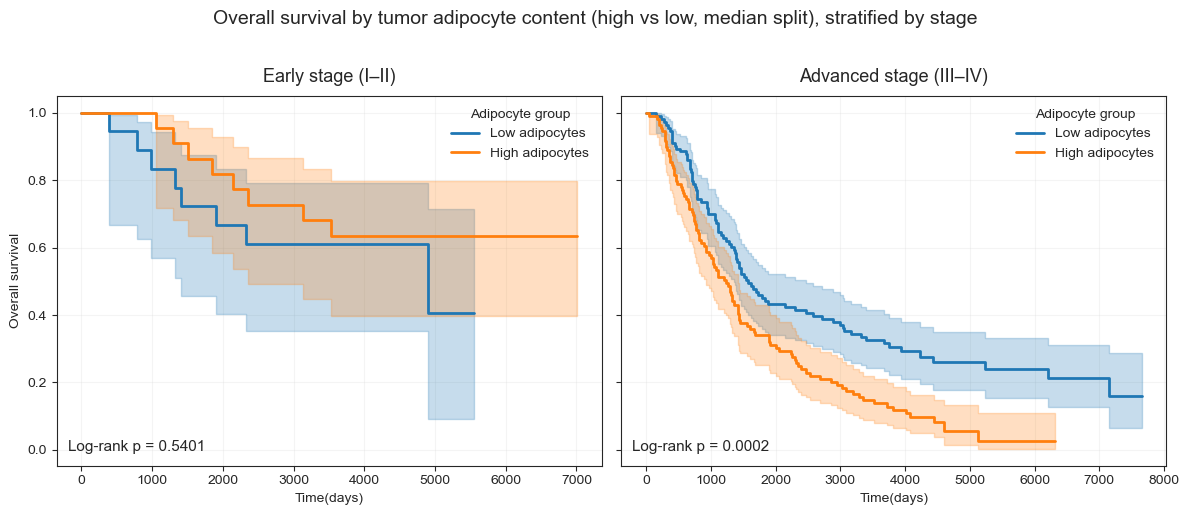

In [72]:
if cell_types_to_use == ["Adipocytes"] and kaplan_meier:
    # ===== KM curves by adipocyte HIGH vs LOW, stratified by Stage (early vs advanced) =====

    # ---------- Prep ----------
    df = cox_df.copy()

    # Keep required columns and drop rows with missing essentials
    req = ["Time-Days", "Event", "Adipocytes", "Stage"]
    km = df[req].dropna(subset=req).copy()
    km["Time-Days"] = km["Time-Days"].astype(float)
    km["Event"] = km["Event"].astype(int)

    # Ensure Stage is 1/2
    km["Stage"] = km["Stage"].astype(int)
    stage_name = {1: "Early stage (I–II)", 2: "Advanced stage (III–IV)"}

    # ---------- Define adipocyte HIGH vs LOW (global median split) ----------
    # Compute global median on all patients
    median_adipo = km["Adipocytes"].median()

    km["AdipoGroup"] = pd.cut(
        km["Adipocytes"],
        bins=[-np.inf, median_adipo, np.inf],
        labels=["Low adipocytes", "High adipocytes"],
    )

    # ensure every patient is assigned
    assert km["AdipoGroup"].notna().all(), "Some rows did not get a high/low label."

    # ---------- Summary tables ----------
    def km_summary(tbl):
        # N, events, median time by adipocyte group
        out = (
            tbl.groupby("AdipoGroup", observed=True)
            .apply(
                lambda g: pd.Series(
                    {
                        "N": len(g),
                        "Events": int(g["Event"].sum()),
                        "Median_time_days": float(
                            KaplanMeierFitter()
                            .fit(g["Time-Days"], g["Event"])
                            .median_survival_time_
                        ),
                    }
                )
            )
            .reset_index()
        )
        return out

    sum_all = km_summary(km).assign(Stage="All")
    sum_s1 = km_summary(km[km["Stage"] == 1]).assign(Stage=stage_name[1])
    sum_s2 = km_summary(km[km["Stage"] == 2]).assign(Stage=stage_name[2])
    summary = pd.concat([sum_all, sum_s1, sum_s2], ignore_index=True)
    print("KM summary (saved to km_adipocytes_summary_by_stage.csv):")
    print(summary)

    # ---------- Plot setup ----------
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    kmf = KaplanMeierFitter()

    for ax_idx, (stage_val, ax) in enumerate(zip([1, 2], axes)):
        sub = km[km["Stage"] == stage_val].copy()
        ax.set_title(stage_name[stage_val], fontsize=13, pad=10)

        # Fit & plot each adipocyte group
        kmfs_for_risk = []
        for label in ["Low adipocytes", "High adipocytes"]:
            g = sub[sub["AdipoGroup"] == label]
            if len(g) == 0:
                continue
            kmf.fit(g["Time-Days"], g["Event"], label=label)
            kmf.plot(ax=ax, ci_show=True, linewidth=2)
            kmfs_for_risk.append(kmf)

        # Ax cosmetics
        ax.set_xlabel("Time(days)")
        if ax_idx == 0:
            ax.set_ylabel("Overall survival")
        ax.grid(alpha=0.2)
        ax.legend(title="Adipocyte group", frameon=False, loc="best")

        # Stage-specific log-rank p-value
        if sub["AdipoGroup"].nunique() >= 2:
            lr = multivariate_logrank_test(
                event_durations=sub["Time-Days"],
                groups=sub["AdipoGroup"],
                event_observed=sub["Event"],
            )
            p = lr.p_value
            ax.text(
                0.02, 0.04, f"Log-rank p = {p:.4f}", transform=ax.transAxes, fontsize=11
            )

    # figure title
    fig.suptitle(
        "Overall survival by tumor adipocyte content (high vs low, median split), stratified by stage",
        y=1.02,
        fontsize=14,
    )
    plt.tight_layout()
    plt.show()